<a href="https://colab.research.google.com/github/frkr/mlearn/blob/master/Apple_Stock_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Closing Price LSTM RNN Models

In [15]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler

In [16]:
# set seeds for max reproducibility

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [26]:
# load the data
!curl -o aapl.csv https://kazmer-nagy-betegh.com/uploads/AAPL.csv

aapl = pd.read_csv('aapl.csv')
aapl.Date = pd.to_datetime(aapl.Date)
aapl.head()

# import the data
# !pip install --upgrade pandas_datareader

# import pandas_datareader as web
# aapl = web.DataReader('AAPL',data_source="yahoo",start='2015-01-01',end='2021-09-30')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  683k  100  683k    0     0  1511k      0 --:--:-- --:--:-- --:--:-- 1514k


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100453,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095213,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088224,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090408,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093029,73449600


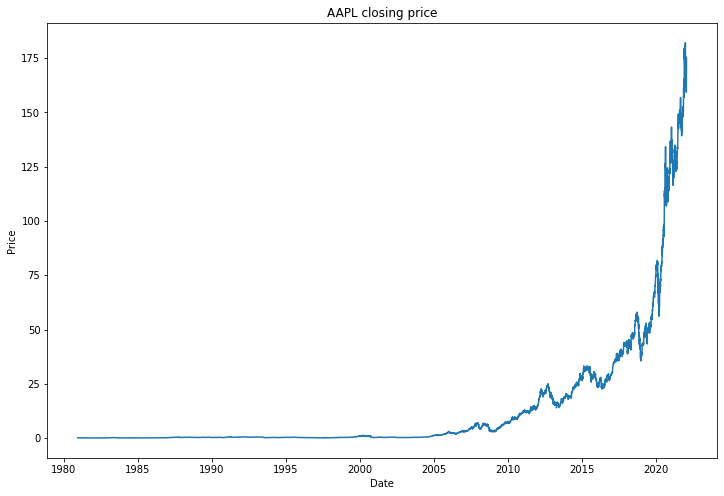

In [28]:
# plot the closing price
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(aapl.Date, aapl['Close'])
ax.set_title('AAPL closing price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

In [30]:
# center all columns apple

apple_norm = aapl.copy()

dates = apple_norm['Date']

dates = pd.to_datetime(dates)

apple_norm = apple_norm.drop(['Date'], axis=1)

a_scaler = MinMaxScaler(feature_range=(0, 1))

apple_norm = pd.DataFrame(a_scaler.fit_transform(apple_norm), columns=apple_norm.columns)

apple_norm.head()

,Open,High,Low,Close,Adj Close,Volume
0,0.000431,0.000433,0.000443,0.000435,0.000341,0.063198
1,0.000397,0.000397,0.000405,0.000399,0.000312,0.023699
2,0.000348,0.000348,0.000355,0.000350,0.000274,0.014246
3,0.000361,0.000363,0.000371,0.000365,0.000286,0.011647
4,0.000379,0.000381,0.000390,0.000383,0.000300,0.009897


In [31]:
n_inputs = 10
n_predictions = 1
batch_size = 32

In [32]:
# training and testing data

train_data = apple_norm[:round(len(apple_norm["Open"])*0.8)]
# valid_data = apple_norm[round(len(apple_norm["Open"])*0.6):]
test_data = apple_norm[round(len(apple_norm["Open"])*0.8):]

In [33]:
 # shape training data for LSTM
n_inputs = 10
n_predictions = 1
batch_size = 32

# save test data for later


X_train = []
y_train = []

for i in range(n_inputs, len(train_data) - n_predictions+1):
    X_train.append(train_data.iloc[i-n_inputs:i , 0:6])
    y_train.append(train_data.iloc[i+n_predictions - 1 : i + n_predictions, 3])


X_train, y_train = np.array(X_train), np.array(y_train)

X_train = keras.backend.cast_to_floatx(X_train)
# y_train = keras.backend.cast_to_floatx(y_train)

print(X_train.shape)
print(y_train.shape)

(8288, 10, 6)
(8288, 1)


In [34]:
def preprocess_lstm(df,n_inputs=10, n_predictions=1, n_features=6):

    X_train = []
    y_train = []


    for i in range(n_inputs, len(df) - n_predictions+1):
        X_train.append(df.iloc[i-n_inputs:i , 0:n_features])
        y_train.append(df["Close"][i : i + n_predictions])


    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train

In [35]:
# build LSTM model

model_lstm = Sequential()

model_lstm.add(LSTM(units=64, 
                    return_sequences=False,
                    input_shape=(10, 6)
                    ))

model_lstm.add(Dense(units=1))


model_lstm.compile(optimizer='adam', 
                    loss='logcosh',
                    metrics= "mse")

In [36]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [37]:
# early stopping
early_s = EarlyStopping(monitor='val_loss',patience=15)

In [38]:
X_train, y_train = preprocess_lstm(train_data, n_inputs=10, n_predictions=1, n_features=6)
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[early_s], verbose=0)

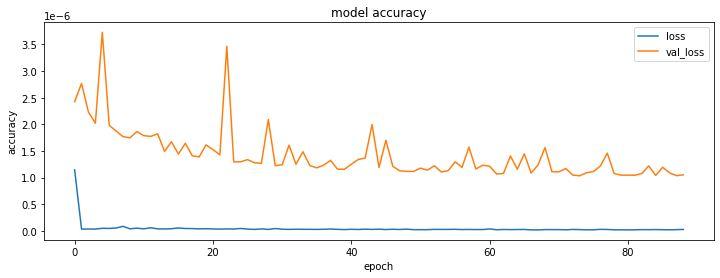

In [39]:
fig, ax = plt.subplots( figsize=(12, 4))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

In [40]:
X_testing, y_testing = preprocess_lstm(test_data, n_inputs=10, n_predictions=1, n_features=6)

y_predicted = model_lstm.predict(X_testing)

65/65 [==============================] - 2s 5ms/step


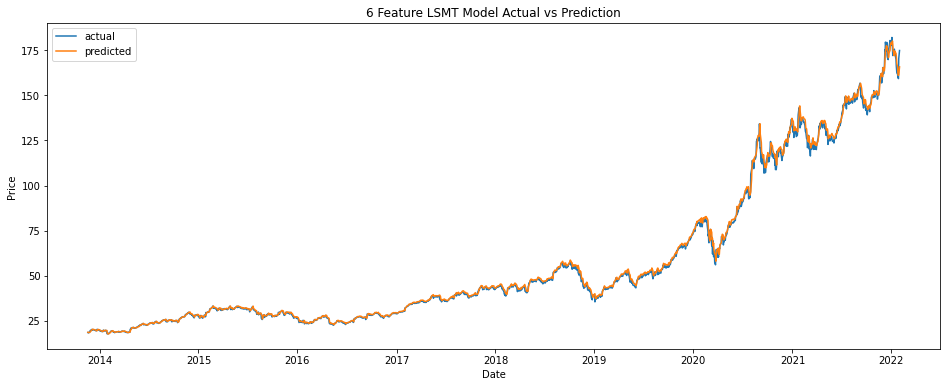

In [41]:
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(16, 6))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title('6 Feature LSMT Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()

# Create the LSTM model

In [47]:
apple_norm = aapl.copy()

dates = apple_norm['Date']

dates = pd.to_datetime(dates)

apple_norm = apple_norm.drop(['Date'], axis=1)

a_scaler = MinMaxScaler(feature_range=(0, 1))

apple_norm = pd.DataFrame(a_scaler.fit_transform(apple_norm), columns=apple_norm.columns)

apple_norm.head()

,Open,High,Low,Close,Adj Close,Volume
0,0.000431,0.000433,0.000443,0.000435,0.000341,0.063198
1,0.000397,0.000397,0.000405,0.000399,0.000312,0.023699
2,0.000348,0.000348,0.000355,0.000350,0.000274,0.014246
3,0.000361,0.000363,0.000371,0.000365,0.000286,0.011647
4,0.000379,0.000381,0.000390,0.000383,0.000300,0.009897


In [48]:
n_inputs = 10
n_predictions = 1
batch_size = 32

In [49]:
# training and testing data

train_data = apple_norm[:round(len(apple_norm["Open"])*0.8)]
# valid_data = apple_norm[round(len(apple_norm["Open"])*0.6):]
test_data = apple_norm[round(len(apple_norm["Open"])*0.8):]


In [50]:
def preprocess_lstm(df,n_inputs=10, n_predictions=1, n_features=6):

    X_train = []
    y_train = []


    for i in range(n_inputs, len(df) - n_predictions+1):
        X_train.append(df.iloc[i-n_inputs:i , 0:n_features])
        y_train.append(df["Close"][i : i + n_predictions])


    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train


In [51]:
# build LSTM model

model_lstm = Sequential()

model_lstm.add(LSTM(units=64, 
                    return_sequences=False,
                    input_shape=(10, 6)
                    ))

model_lstm.add(Dense(units=1))


model_lstm.compile(optimizer='adam', 
                    loss='logcosh',
                    metrics= "mse")


In [52]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [53]:
# early stopping
early_s = EarlyStopping(monitor='val_loss',patience=15)

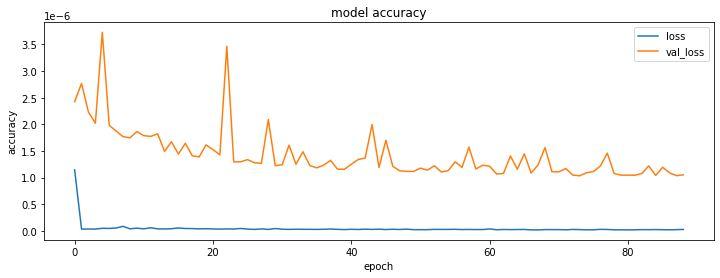

In [54]:
fig, ax = plt.subplots( figsize=(12, 4))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

In [55]:
X_testing, y_testing = preprocess_lstm(test_data, n_inputs=10, n_predictions=1, n_features=6)

y_predicted = model_lstm.predict(X_testing)

65/65 [==============================] - 1s 3ms/step


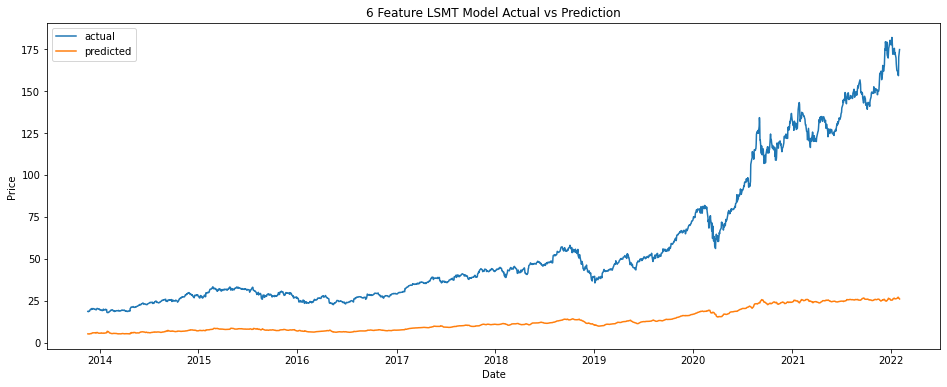

In [56]:
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(16, 6))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title('6 Feature LSMT Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()

# Model Variations Question B

# Simple RNN with only Close Price as Feature

In [57]:
# build RNN model

model_rnn_single = Sequential()

model_rnn_single.add(SimpleRNN(units=64, 
                    return_sequences=False,
                    input_shape=(10, 1)
                    ))

model_rnn_single.add(Dense(units=1))


model_rnn_single.compile(optimizer='adam', 
                    loss='logcosh',
                    metrics= "mse")


In [58]:
X_train, y_train = preprocess_lstm(pd.DataFrame(train_data["Close"]), n_inputs=10, n_predictions=1, n_features=1)


In [59]:
early_s = EarlyStopping(monitor='val_loss',patience=5)


In [60]:
history = model_rnn_single.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2, callbacks=[early_s], verbose=0)


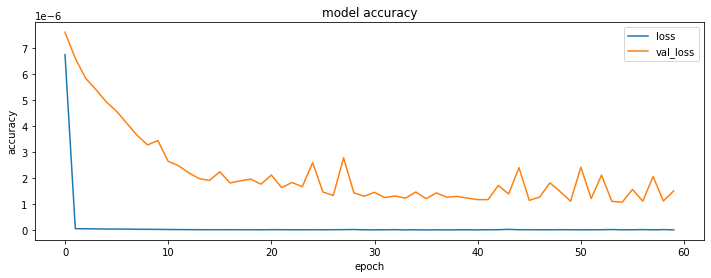

In [61]:
fig, ax = plt.subplots( figsize=(12, 4))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

65/65 [==============================] - 0s 2ms/step


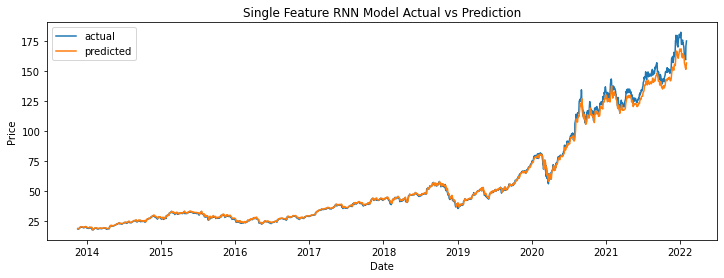

In [62]:
# plot the predicted and actual values

X_testing, y_testing = preprocess_lstm(pd.DataFrame(test_data["Close"]), n_inputs=10, n_predictions=1, n_features=1)
y_predicted = model_rnn_single.predict(X_testing)
# Rescale the predicted values
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(12, 4))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title('Single Feature RNN Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()

# Multi Feature RNN


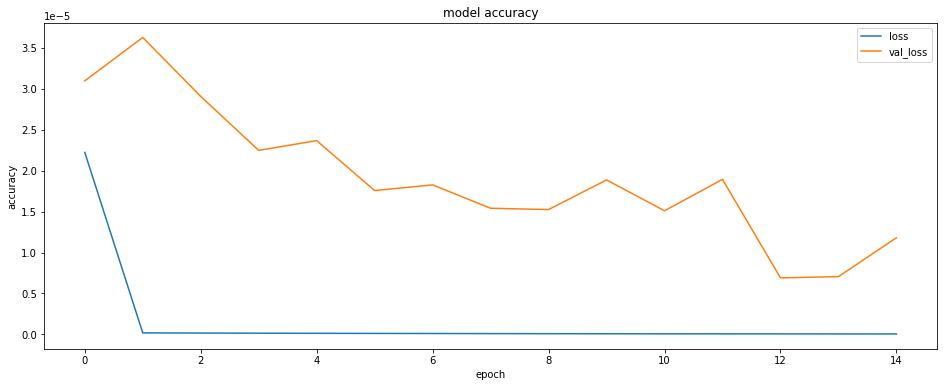

In [63]:
# build RNN model

n_features = 5

model_rnn_multi = Sequential()

model_rnn_multi.add(SimpleRNN(units=64, 
                    return_sequences=False,
                    input_shape=(10, n_features)
                    ))

model_rnn_multi.add(Dense(units=1))


model_rnn_multi.compile(optimizer='adam', 
                    loss='logcosh',
                    metrics= "mse")

X_train, y_train = preprocess_lstm(train_data, n_inputs=10, n_predictions=1, n_features=n_features)
early_s = EarlyStopping(monitor='val_loss',patience=3)
history_rnn_multi = model_rnn_multi.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, callbacks=[early_s], verbose=0)
fig, ax = plt.subplots( figsize=(16, 6))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history_rnn_multi.history['loss'], label = 'loss')
ax.plot(history_rnn_multi.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

In [64]:
X_train, y_train = preprocess_lstm(train_data, n_inputs=10, n_predictions=1, n_features=n_features)


In [65]:
early_s = EarlyStopping(monitor='val_loss',patience=3)


In [66]:
history_rnn_multi = model_rnn_multi.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, callbacks=[early_s], verbose=0)


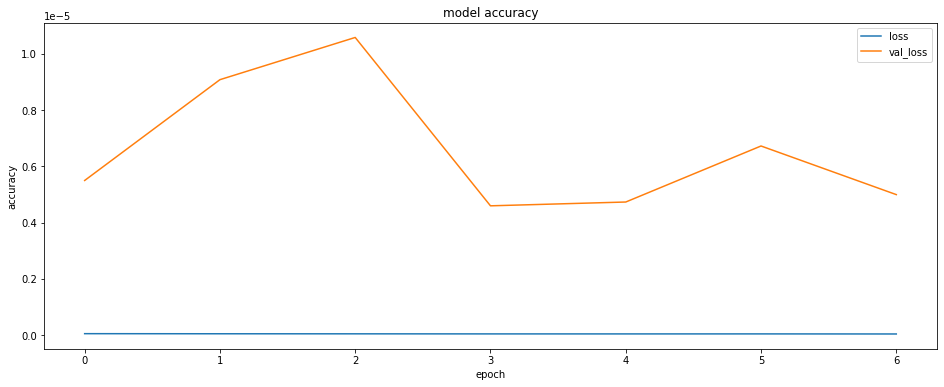

In [67]:
fig, ax = plt.subplots( figsize=(16, 6))
# ax.plot(history.history['accuracy'], label = 'accuracy', )
ax.plot(history_rnn_multi.history['loss'], label = 'loss')
ax.plot(history_rnn_multi.history['val_loss'], label = 'val_loss')
# ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()

65/65 [==============================] - 0s 2ms/step


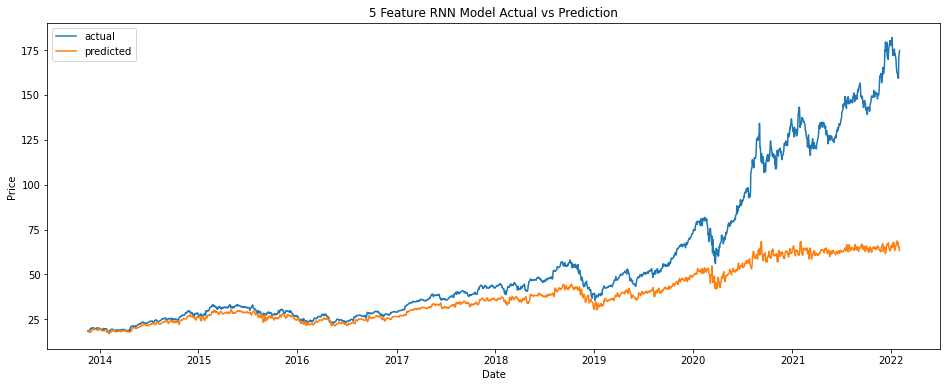

In [68]:
# plot the predicted and actual values
X_testing, y_testing = preprocess_lstm(test_data, n_inputs=10, n_predictions=1, n_features=5)
y_predicted = model_rnn_multi.predict(X_testing)
# Rescale the predicted values
y_testing = (y_testing - a_scaler.min_[3] )/a_scaler.scale_[3]
y_predicted = (y_predicted  - a_scaler.min_[3]  )/a_scaler.scale_[3]

fig, ax = plt.subplots( figsize=(16, 6))
ax.plot(dates[-len(test_data)+n_inputs:],y_testing, label = 'actual')
ax.plot(dates[-len(test_data)+n_inputs:],y_predicted, label = 'predicted')
ax.set_title(f'{n_features} Feature RNN Model Actual vs Prediction')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()